setting up enviroment

In [ ]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
print("Check my GPU", tf.config.list_physical_devices("GPU"))

Check my GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured with memory growth")
else:
    print("No GPU detected")

GPU configured with memory growth


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers


**import dataset and check it**

In [2]:
(img_train, _), (_, _) = keras.datasets.mnist.load_data()


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


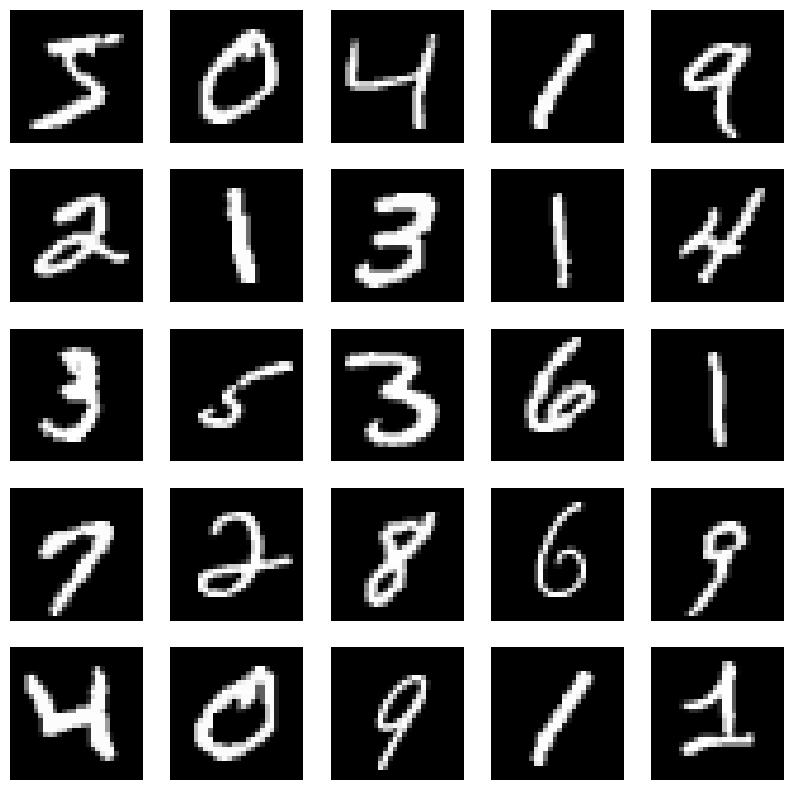

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(img_train[i], cmap="gray")
  plt.axis("off")
plt.show()


**normalize data**

In [4]:
img_train = img_train.reshape(img_train.shape[0], 28, 28, 1).astype("float32")
img_train = (img_train - 127.5) / 127.5


In [5]:
BUFFER_SIZE = 60000
BATCH_SIZE = 64


In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices(img_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [7]:

LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean=0.01, stddev=0.02)

**create a generator and a discriminator**

In [8]:
# Generator Model
def build_generator():
    model = keras.Sequential([
        layers.Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((7, 7, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False, kernel_initializer=WEIGHT_UNIT),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False, kernel_initializer=WEIGHT_UNIT),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')
    ])
    return model

generator = build_generator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
# Discriminator Model
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**create the generator and discriminator losses**

In [10]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


In [11]:

generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

**build a subclass model**

In [12]:
# GAN Class
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as d_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            d_loss = self.d_loss(real_output, fake_output)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss(fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}



**build a callback function**

In [14]:
# Callback to visualize generated images
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100):
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_images, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = (generated_images * 127.5) + 127.5

            plt.figure(figsize=(10,10))
            for i in range(self.num_images):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i].numpy().squeeze(), cmap="gray")
                plt.axis("off")
            plt.show()



**train the model**

In [15]:
EPOCHS = 100


In [16]:
gan = GAN(generator=generator, discriminator=discriminator)
gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - d_loss: 1.2145 - g_loss: 1.0764

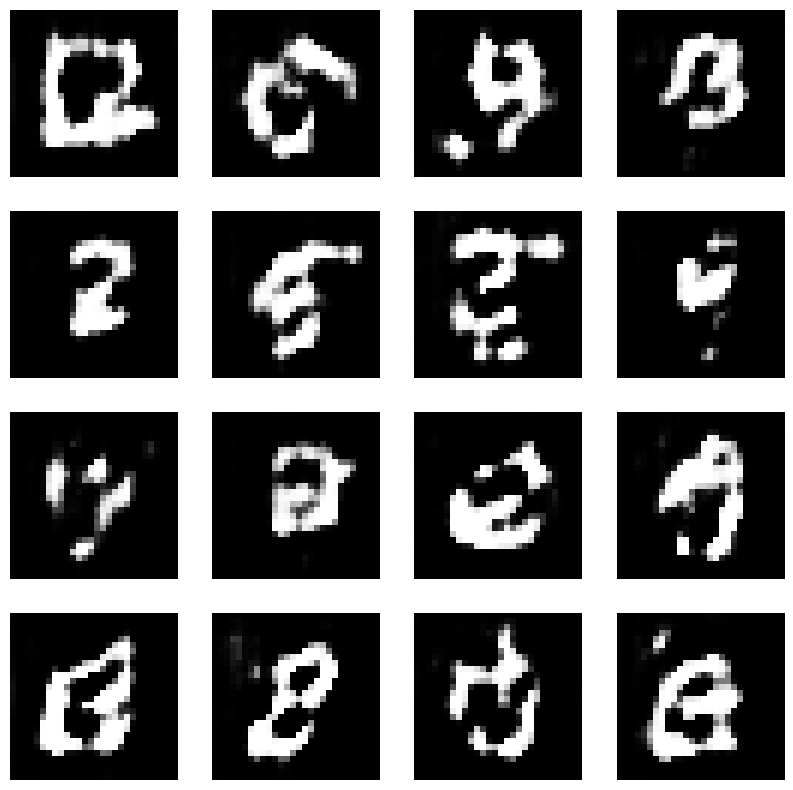

938/938 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - d_loss: 1.2145 - g_loss: 1.0765
Epoch 2/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.2939 - g_loss: 0.9458
Epoch 3/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3361 - g_loss: 0.8875
Epoch 4/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3336 - g_loss: 0.8833
Epoch 5/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3256 - g_loss: 0.8966
Epoch 6/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - d_loss: 1.3173 - g_loss: 0.9031

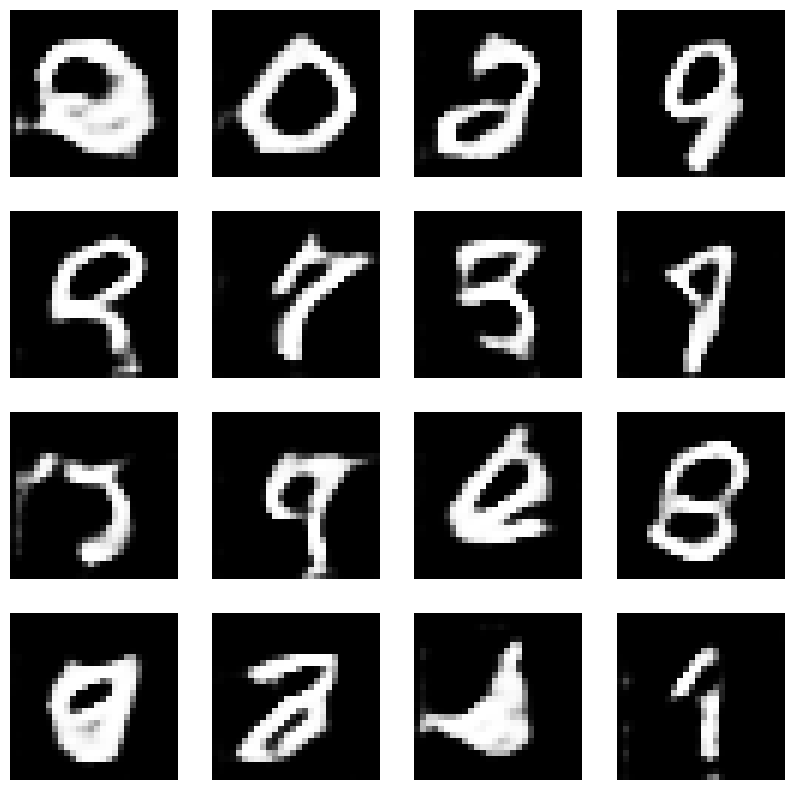

938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - d_loss: 1.3173 - g_loss: 0.9032
Epoch 7/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3102 - g_loss: 0.9198
Epoch 8/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3059 - g_loss: 0.9244
Epoch 9/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3061 - g_loss: 0.9241
Epoch 10/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3075 - g_loss: 0.9261
Epoch 11/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - d_loss: 1.3111 - g_loss: 0.9260

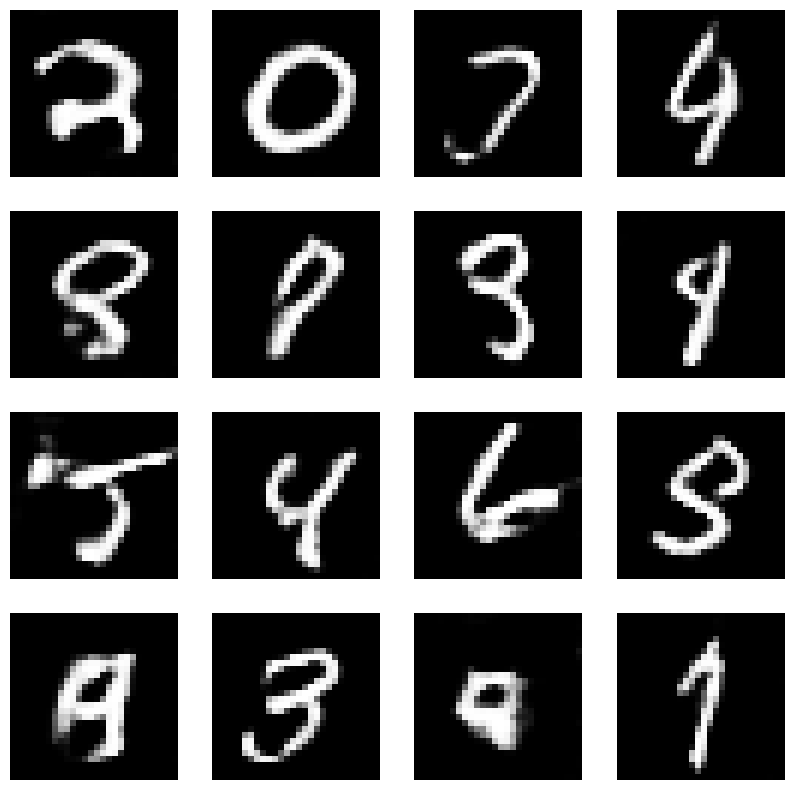

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3110 - g_loss: 0.9258
Epoch 12/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3119 - g_loss: 0.9262
Epoch 13/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3102 - g_loss: 0.9247
Epoch 14/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3100 - g_loss: 0.9232
Epoch 15/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3092 - g_loss: 0.9234
Epoch 16/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3096 - g_loss: 0.9237

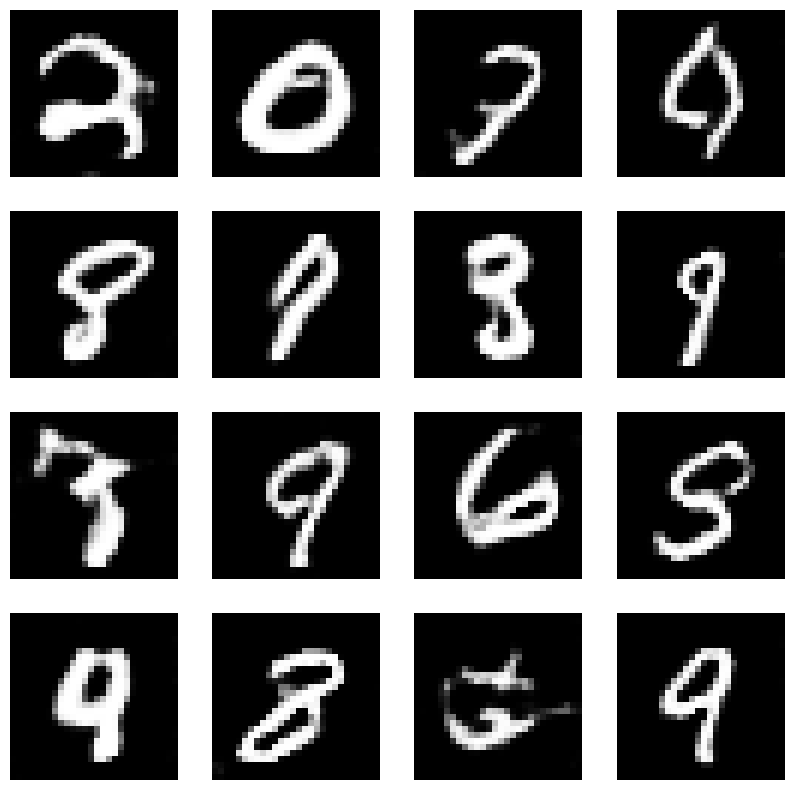

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3096 - g_loss: 0.9236
Epoch 17/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3109 - g_loss: 0.9236
Epoch 18/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - d_loss: 1.3087 - g_loss: 0.9271
Epoch 19/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - d_loss: 1.3090 - g_loss: 0.9275
Epoch 20/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3073 - g_loss: 0.9300
Epoch 21/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3066 - g_loss: 0.9326

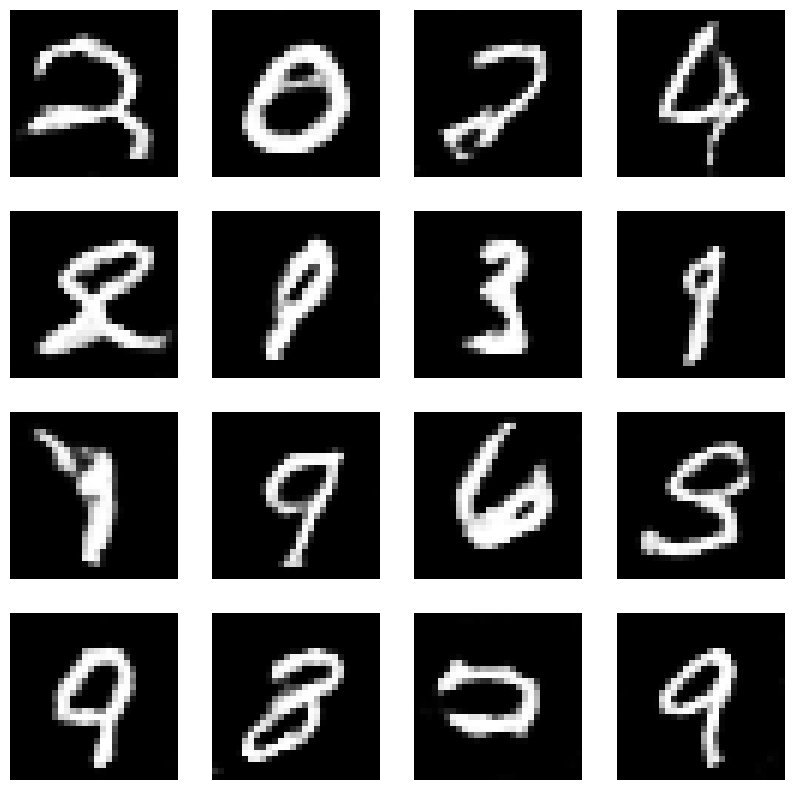

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3067 - g_loss: 0.9324
Epoch 22/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3055 - g_loss: 0.9329
Epoch 23/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3042 - g_loss: 0.9364
Epoch 24/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3050 - g_loss: 0.9354
Epoch 25/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3032 - g_loss: 0.9377
Epoch 26/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3041 - g_loss: 0.9392

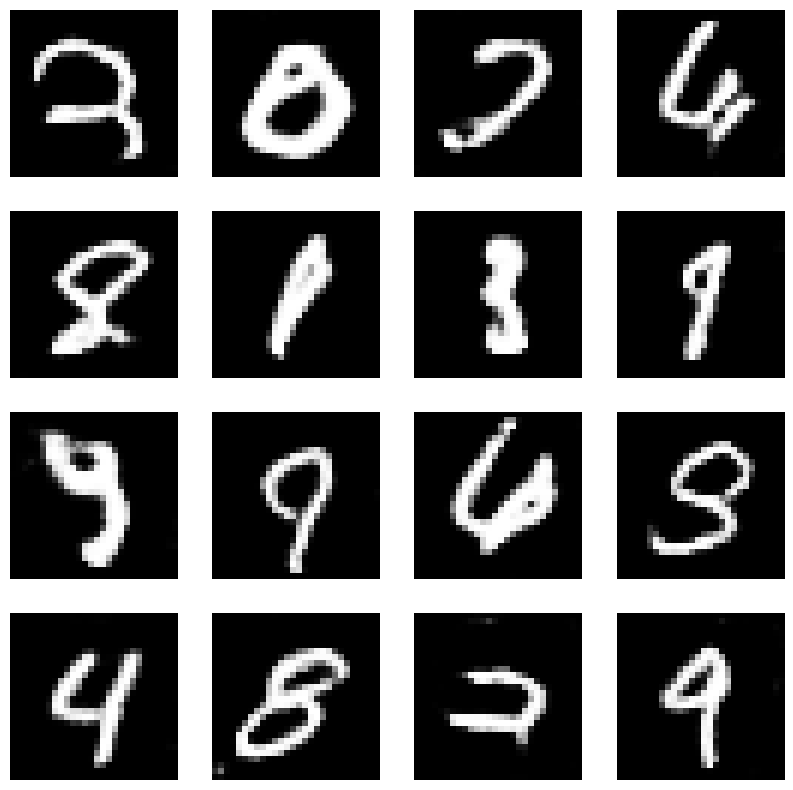

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3042 - g_loss: 0.9393
Epoch 27/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3033 - g_loss: 0.9405
Epoch 28/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3001 - g_loss: 0.9417
Epoch 29/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3027 - g_loss: 0.9415
Epoch 30/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.2989 - g_loss: 0.9467
Epoch 31/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3003 - g_loss: 0.9488

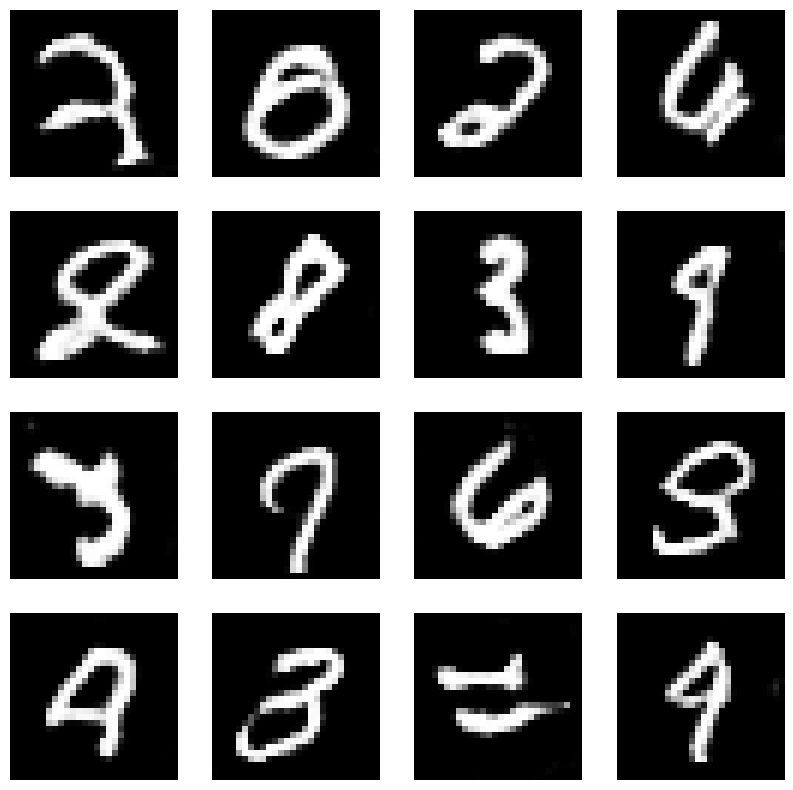

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3003 - g_loss: 0.9490
Epoch 32/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3000 - g_loss: 0.9472
Epoch 33/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - d_loss: 1.3012 - g_loss: 0.9478
Epoch 34/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.2985 - g_loss: 0.9463
Epoch 35/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3017 - g_loss: 0.9503
Epoch 36/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3003 - g_loss: 0.9507

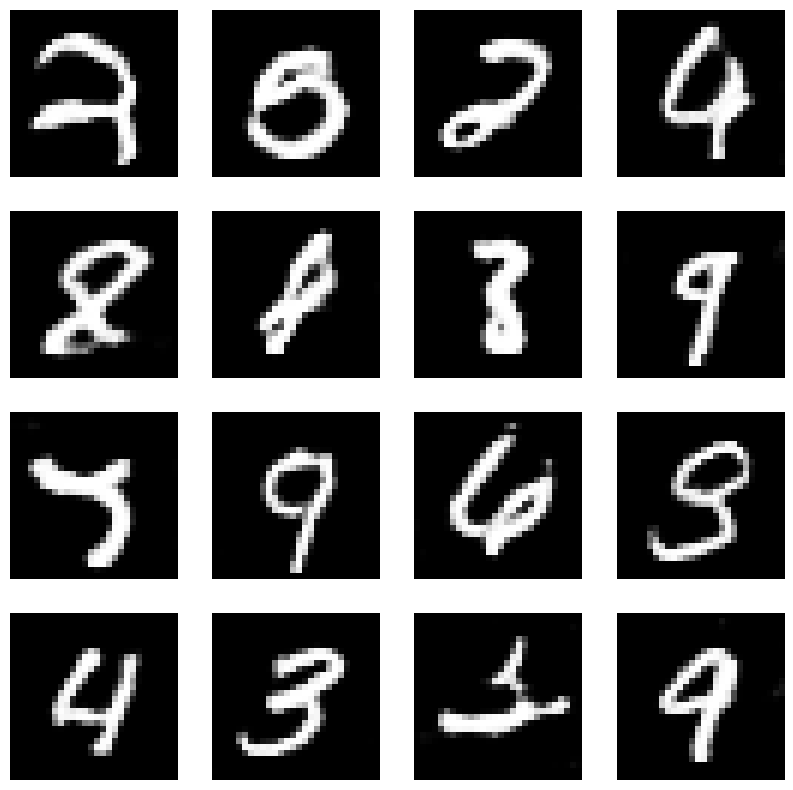

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3002 - g_loss: 0.9507
Epoch 37/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.2995 - g_loss: 0.9462
Epoch 38/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - d_loss: 1.2979 - g_loss: 0.9482
Epoch 39/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.2963 - g_loss: 0.9545
Epoch 40/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3000 - g_loss: 0.9536
Epoch 41/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.2992 - g_loss: 0.9562

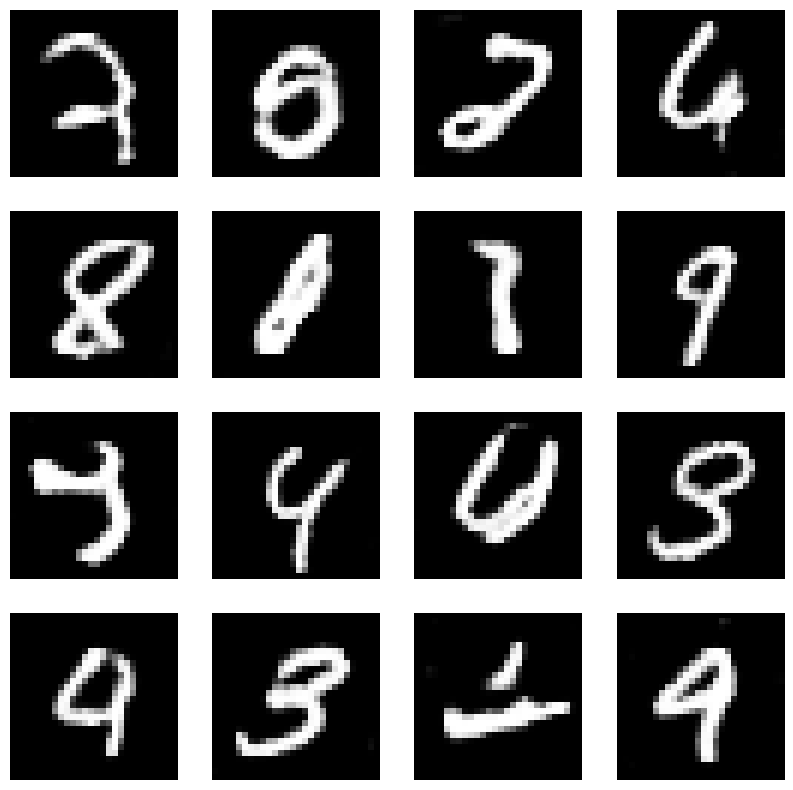

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.2993 - g_loss: 0.9563
Epoch 42/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3003 - g_loss: 0.9538
Epoch 43/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.2956 - g_loss: 0.9537
Epoch 44/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.2965 - g_loss: 0.9544
Epoch 45/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.2975 - g_loss: 0.9540
Epoch 46/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.2983 - g_loss: 0.9546

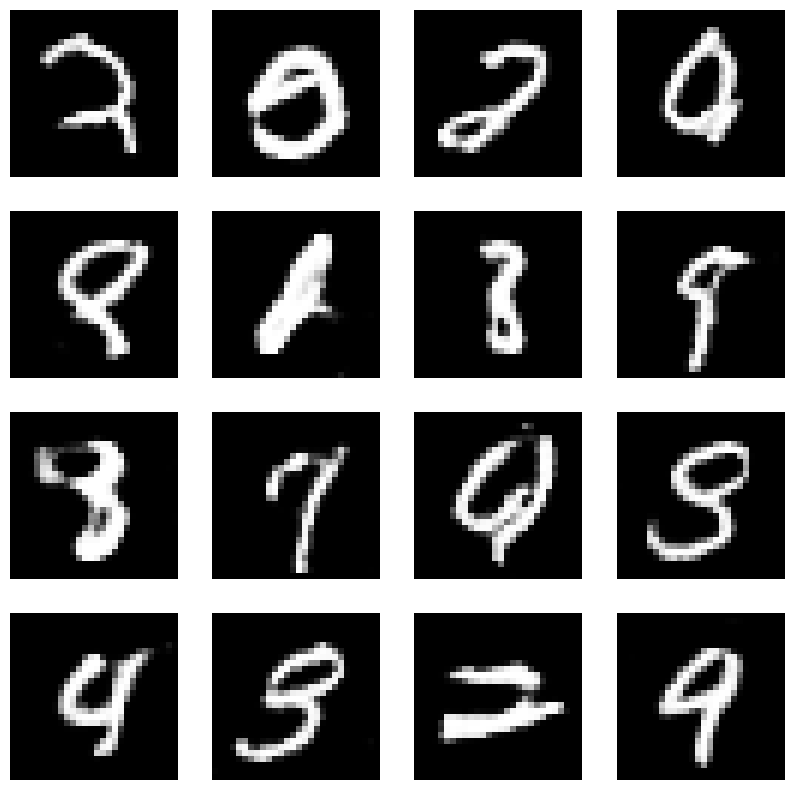

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.2983 - g_loss: 0.9544
Epoch 47/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.2973 - g_loss: 0.9533
Epoch 48/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.2997 - g_loss: 0.9561
Epoch 49/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.2995 - g_loss: 0.9541
Epoch 50/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.2974 - g_loss: 0.9540
Epoch 51/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3006 - g_loss: 0.9542

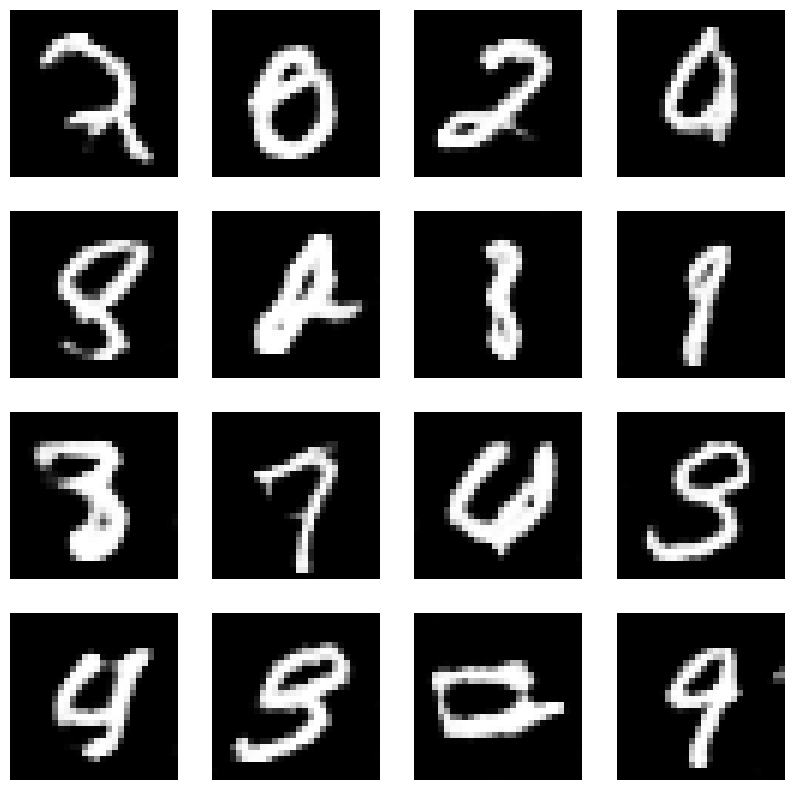

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3004 - g_loss: 0.9540
Epoch 52/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.2996 - g_loss: 0.9530
Epoch 53/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3021 - g_loss: 0.9520
Epoch 54/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3014 - g_loss: 0.9513
Epoch 55/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.2988 - g_loss: 0.9527
Epoch 56/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3006 - g_loss: 0.9521

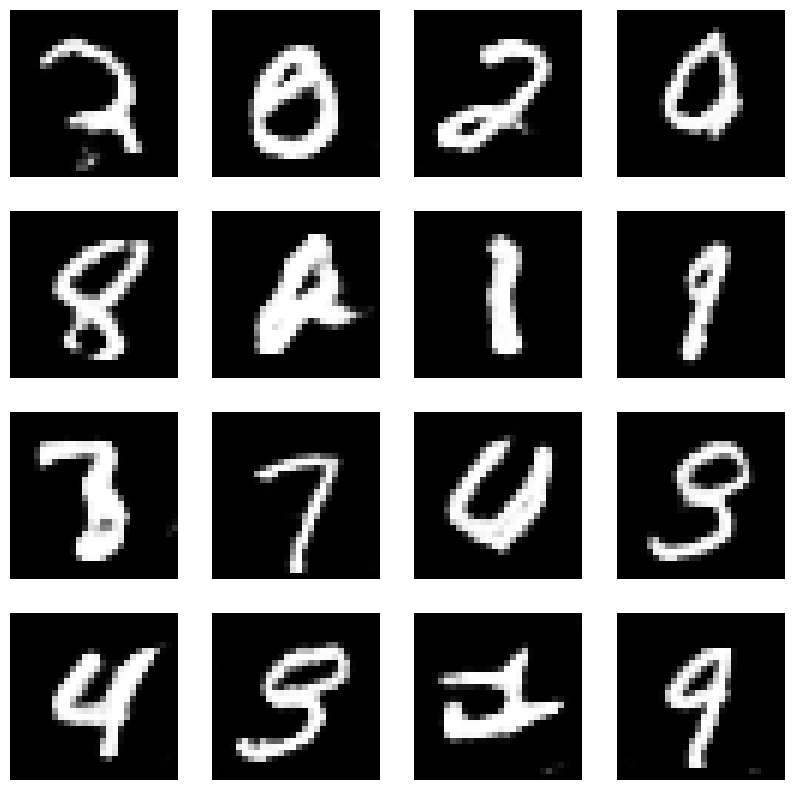

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3005 - g_loss: 0.9521
Epoch 57/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3010 - g_loss: 0.9506
Epoch 58/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3008 - g_loss: 0.9504
Epoch 59/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3018 - g_loss: 0.9543
Epoch 60/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3025 - g_loss: 0.9508
Epoch 61/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3016 - g_loss: 0.9504

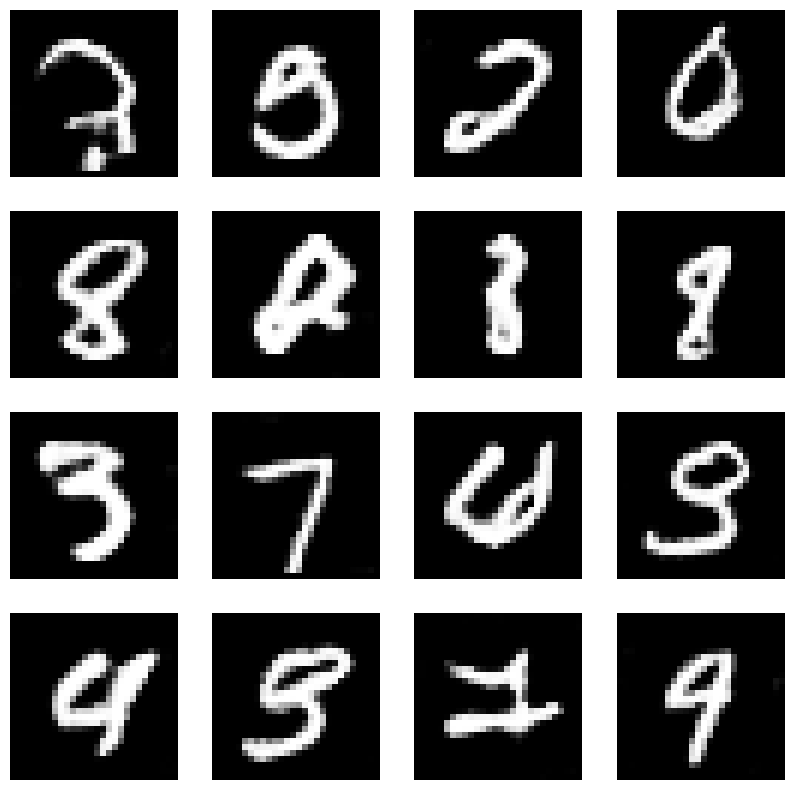

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3014 - g_loss: 0.9505
Epoch 62/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3015 - g_loss: 0.9497
Epoch 63/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3023 - g_loss: 0.9511
Epoch 64/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3008 - g_loss: 0.9522
Epoch 65/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3020 - g_loss: 0.9518
Epoch 66/100
936/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3021 - g_loss: 0.9514

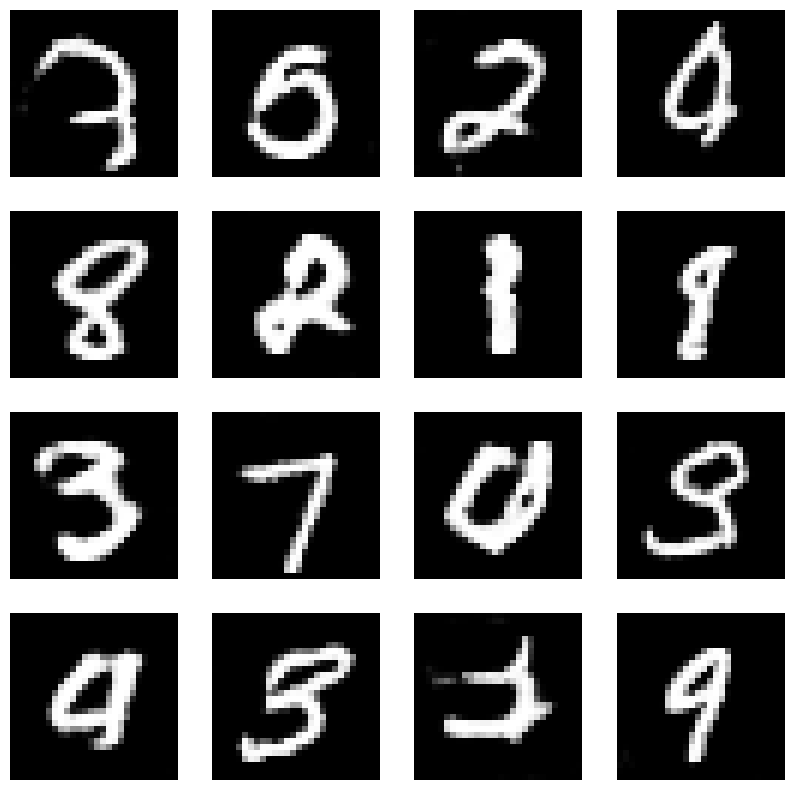

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3022 - g_loss: 0.9514
Epoch 67/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3017 - g_loss: 0.9502
Epoch 68/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3047 - g_loss: 0.9482
Epoch 69/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3031 - g_loss: 0.9473
Epoch 70/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - d_loss: 1.3039 - g_loss: 0.9496
Epoch 71/100
935/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3024 - g_loss: 0.9511

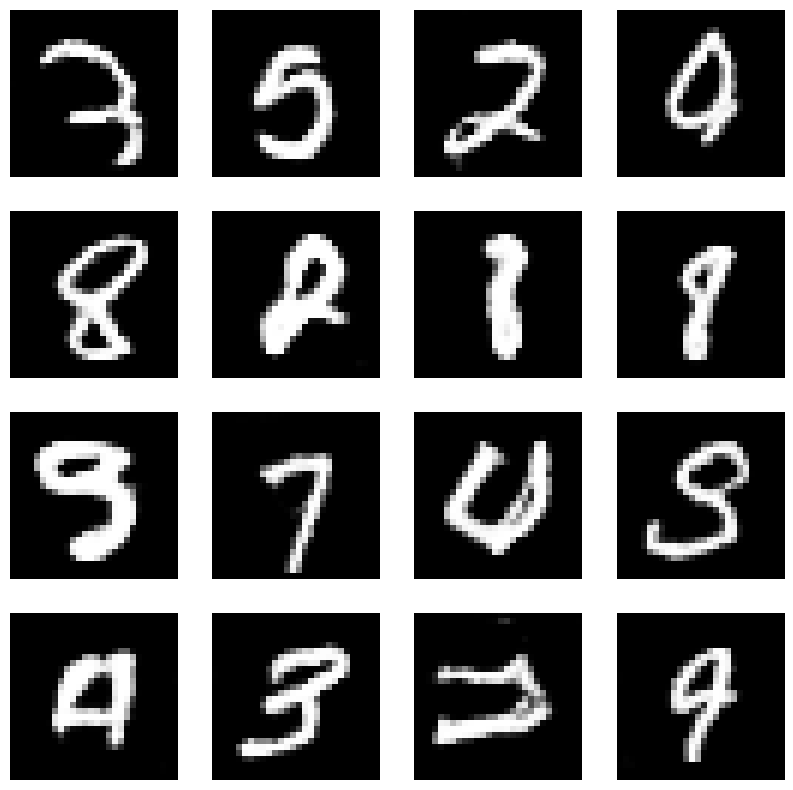

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3023 - g_loss: 0.9509
Epoch 72/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3055 - g_loss: 0.9501
Epoch 73/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3050 - g_loss: 0.9476
Epoch 74/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3058 - g_loss: 0.9450
Epoch 75/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3061 - g_loss: 0.9443
Epoch 76/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3063 - g_loss: 0.9433

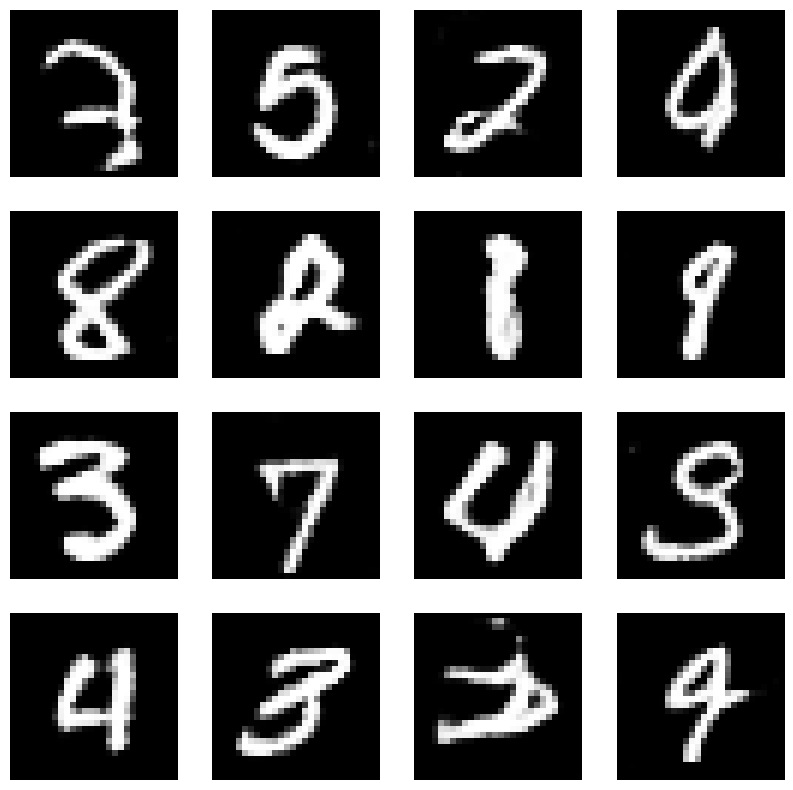

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3061 - g_loss: 0.9432
Epoch 77/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3065 - g_loss: 0.9444
Epoch 78/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - d_loss: 1.3059 - g_loss: 0.9466
Epoch 79/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - d_loss: 1.3086 - g_loss: 0.9434
Epoch 80/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3069 - g_loss: 0.9403
Epoch 81/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3090 - g_loss: 0.9435

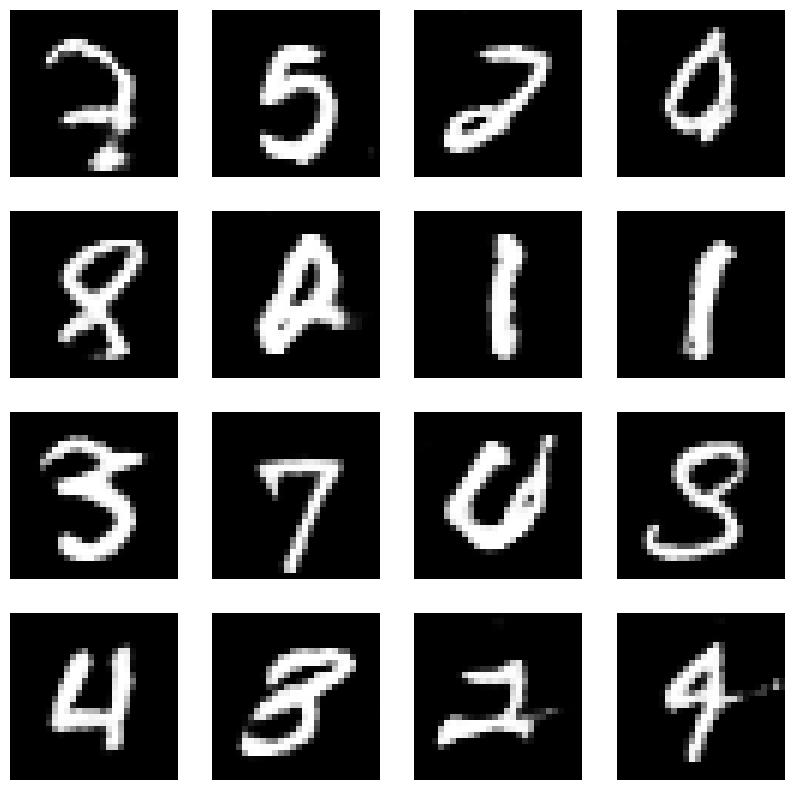

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3089 - g_loss: 0.9432
Epoch 82/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - d_loss: 1.3081 - g_loss: 0.9404
Epoch 83/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3090 - g_loss: 0.9398
Epoch 84/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3082 - g_loss: 0.9403
Epoch 85/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3089 - g_loss: 0.9383
Epoch 86/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3086 - g_loss: 0.9391

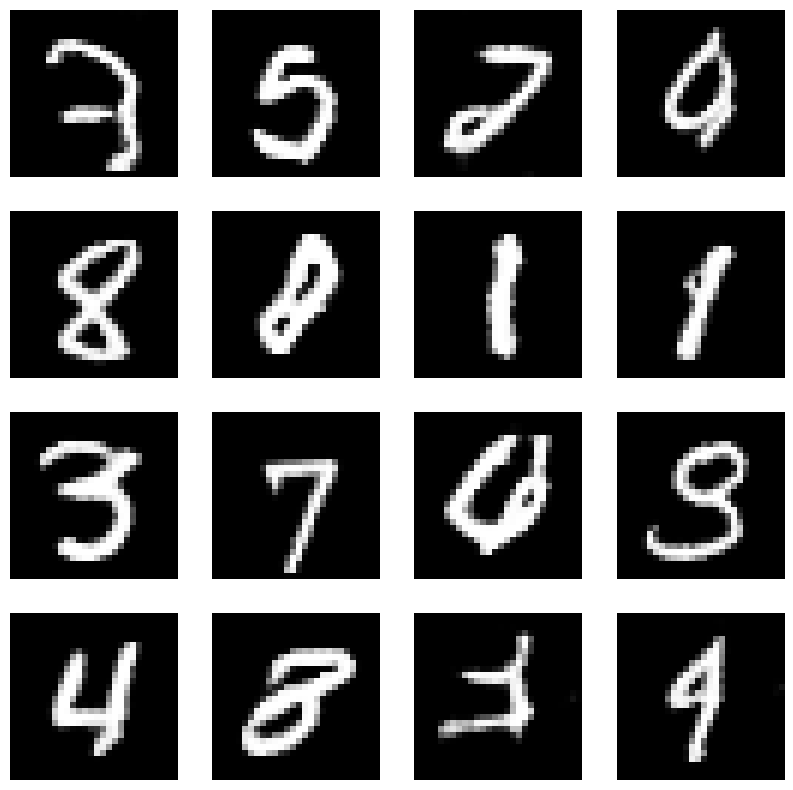

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3085 - g_loss: 0.9391
Epoch 87/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3091 - g_loss: 0.9375
Epoch 88/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3083 - g_loss: 0.9374
Epoch 89/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3111 - g_loss: 0.9363
Epoch 90/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3116 - g_loss: 0.9364
Epoch 91/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - d_loss: 1.3105 - g_loss: 0.9385

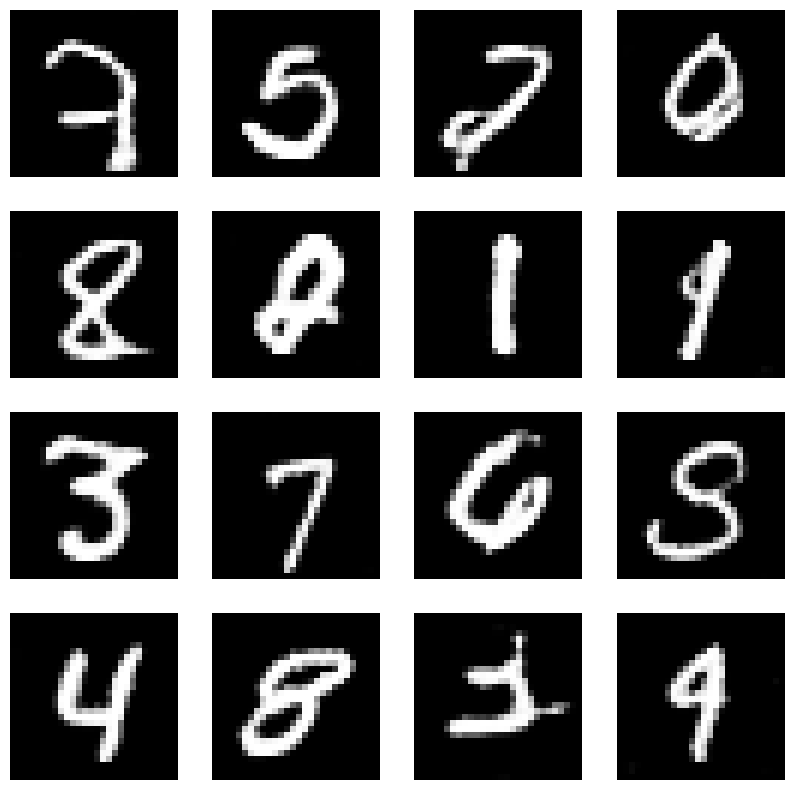

938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3108 - g_loss: 0.9382
Epoch 92/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3119 - g_loss: 0.9379
Epoch 93/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3121 - g_loss: 0.9379
Epoch 94/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3118 - g_loss: 0.9370
Epoch 95/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3114 - g_loss: 0.9313
Epoch 96/100
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - d_loss: 1.3107 - g_loss: 0.9365

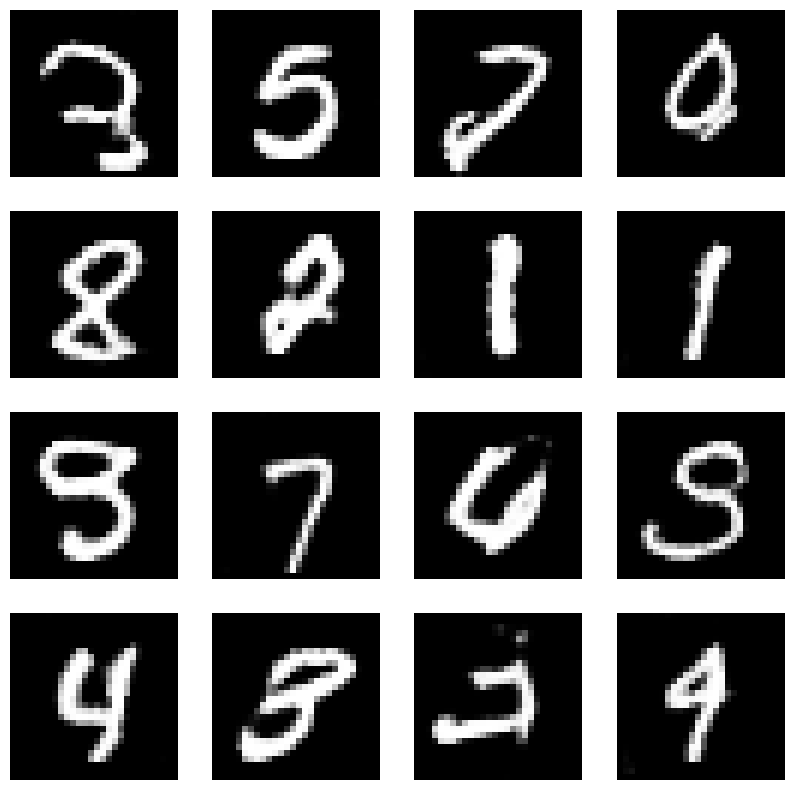

938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - d_loss: 1.3106 - g_loss: 0.9362
Epoch 97/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3107 - g_loss: 0.9358
Epoch 98/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - d_loss: 1.3098 - g_loss: 0.9336
Epoch 99/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - d_loss: 1.3142 - g_loss: 0.9360
Epoch 100/100
938/938 ━━━━━━━━━━━━━━━━━━━━ 21s 15ms/step - d_loss: 1.3141 - g_loss: 0.9320


In [17]:
history = gan.fit(train_dataset, epochs=EPOCHS, callbacks=[ImageCallback()])


**evaluate the model and save it**

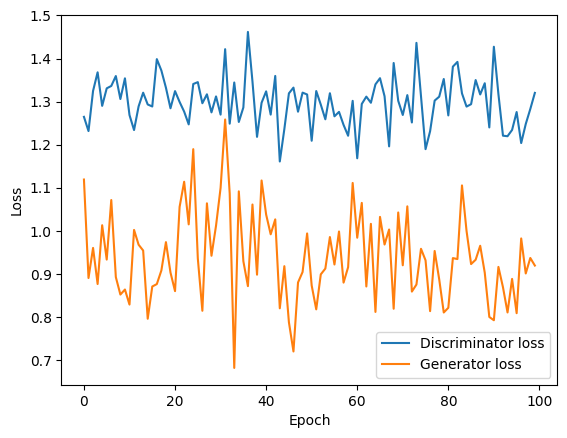

In [18]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5


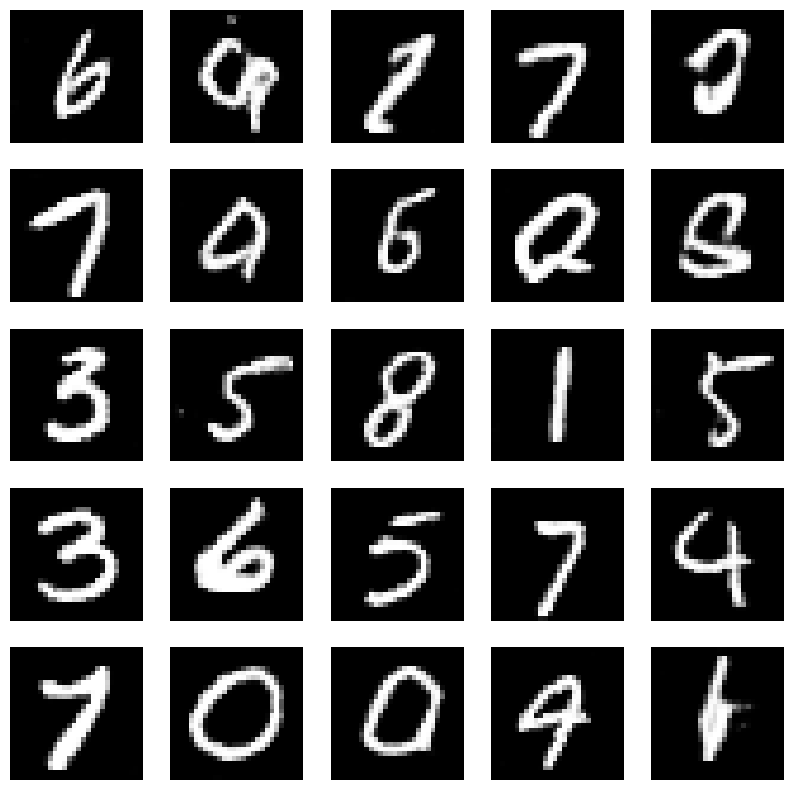

In [20]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().squeeze(), cmap="gray")
  plt.axis("off")
plt.show()


In [21]:
generator.save("mnist_generator.h5")
